# Test code

This Jupyter Notebook serves as the foundation for the `anonymization_utils.py` file. It contains the necessary code and steps to perform text anonymization, pseudonymization, and simplification using various libraries and custom implementations. The notebook ensures that all components work together seamlessly and provides a comprehensive workflow for text processing and evaluation.

The key functionalities demonstrated in this notebook include:

1. **Text Anonymization**: Using the Presidio library to identify and anonymize sensitive entities in the text.
2. **Text Pseudonymization**: Implementing a custom anonymizer to replace entities with a consistent format.
3. **Text Simplification**: Utilizing a pre-trained model to simplify the anonymized and pseudonymized text.
4. **Evaluation**: Calculating SARI scores and comparing entity recognition metrics to evaluate the effectiveness of the anonymization and simplification processes.

By following the steps and code provided in this notebook, you can ensure that the `anonymization_utils.py` file functions correctly and achieves the desired outcomes for text anonymization and simplification.

For a practical example of how to use the `anonymization_utils.py` file, please refer to `example.ipynb`.

In [20]:
from presidio_analyzer import AnalyzerEngine
from presidio_analyzer.nlp_engine import SpacyNlpEngine
from presidio_anonymizer import AnonymizerEngine, DeanonymizeEngine, OperatorConfig
from presidio_anonymizer.operators import Operator, OperatorType

from typing import Dict
from pprint import pprint
import spacy

from transformers import pipeline, AutoTokenizer

import matplotlib.pyplot as plt

from nltk.tokenize import sent_tokenize
import spacy
from evaluate import load
from sklearn.metrics import precision_recall_fscore_support



In [21]:
class LoadedSpacyNlpEngine(SpacyNlpEngine):
    def __init__(self, loaded_spacy_model):
        super().__init__()
        self.nlp = {"nl": loaded_spacy_model}

nlp = spacy.load("nl_core_news_lg")

loaded_nlp_engine = LoadedSpacyNlpEngine(loaded_spacy_model = nlp)


In [22]:
text = '''
Geachte klantenservice van Coolblue,

Mijn naam is Bram Ekelschot en met deze brief wil ik mijn ernstige ongenoegen uiten over zowel de levering als de klantenservice van Coolblue. Op 5 januari 2025 heb ik via uw website, www.coolblue.nl, een bestelling geplaatst voor een Samsung Galaxy S23 Ultra (512GB, Phantom Black). Het ordernummer van deze bestelling is CB2025001234. Volgens de orderbevestiging zou het pakket op 7 januari 2025 bezorgd worden op mijn huisadres in Amsterdam. Helaas is de levering met maar liefst vijf dagen vertraagd, waardoor ik het toestel pas op 12 januari 2025 heb ontvangen.

Tot mijn grote teleurstelling bleek bij het uitpakken dat de Samsung Galaxy S23 Ultra beschadigd was. De behuizing had zichtbare krassen en de camera vertoonde een defect, waardoor het toestel niet naar behoren functioneerde. Direct op 13 januari 2025 heb ik telefonisch contact opgenomen met uw klantenservice via het telefoonnummer 010-798 8999. Een medewerker, genaamd Mark van den Berg, verzekerde mij dat er binnen drie werkdagen een passende oplossing zou komen, zoals een vervangend toestel of een terugbetaling van het aankoopbedrag van €1.399,-. Helaas heb ik tot op heden niets van u vernomen.

Na meerdere vergeefse pogingen om telefonisch en per e-mail contact met Coolblue op te nemen, zie ik mij genoodzaakt deze klacht schriftelijk in te dienen. Ik verzoek u dan ook dringend om binnen vijf werkdagen met een oplossing te komen. Dit kan in de vorm van een vervangend toestel, een volledige terugbetaling van het aankoopbedrag of een alternatieve compensatie. Daarnaast verwacht ik een vergoeding voor het ongemak dat ik heb ondervonden door de vertraging en de gebrekkige klantenservice.

Indien er geen tijdige en bevredigende oplossing komt, zal ik mij genoodzaakt zien verdere stappen te ondernemen. Ik overweeg een klacht in te dienen bij de Consumentenbond en, indien nodig, een formele melding te maken bij de Autoriteit Consument & Markt (ACM). Daarnaast behoud ik mij het recht voor om juridische stappen te ondernemen via een geschillencommissie of een gerechtelijke procedure.

Ik verzoek u vriendelijk om mij per omgaande te informeren over de voortgang van mijn klacht. U kunt mij schriftelijk bereiken op mijn woonadres in Amsterdam of per e-mail via bram.ekelschot@gmail.com. Bij deze brief voeg ik een kopie van mijn bestelbevestiging, de factuur en foto’s van het beschadigde product toe ter ondersteuning van mijn klacht.

Ik vertrouw erop dat Coolblue zijn verantwoordelijkheid zal nemen en op korte termijn met een passende oplossing zal komen. Ik zie uw reactie dan ook met belangstelling tegemoet.

Met vriendelijke groet,

Bram Ekelschot
'''


print("originele tekst:")
pprint(text)
analyzer = AnalyzerEngine(nlp_engine = loaded_nlp_engine)
analyzer_results = analyzer.analyze(text=text, language="nl")
print("analyzer results:")
pprint(analyzer_results)


originele tekst:
('\n'
 'Geachte klantenservice van Coolblue,\n'
 '\n'
 'Mijn naam is Bram Ekelschot en met deze brief wil ik mijn ernstige '
 'ongenoegen uiten over zowel de levering als de klantenservice van Coolblue. '
 'Op 5 januari 2025 heb ik via uw website, www.coolblue.nl, een bestelling '
 'geplaatst voor een Samsung Galaxy S23 Ultra (512GB, Phantom Black). Het '
 'ordernummer van deze bestelling is CB2025001234. Volgens de orderbevestiging '
 'zou het pakket op 7 januari 2025 bezorgd worden op mijn huisadres in '
 'Amsterdam. Helaas is de levering met maar liefst vijf dagen vertraagd, '
 'waardoor ik het toestel pas op 12 januari 2025 heb ontvangen.\n'
 '\n'
 'Tot mijn grote teleurstelling bleek bij het uitpakken dat de Samsung Galaxy '
 'S23 Ultra beschadigd was. De behuizing had zichtbare krassen en de camera '
 'vertoonde een defect, waardoor het toestel niet naar behoren functioneerde. '
 'Direct op 13 januari 2025 heb ik telefonisch contact opgenomen met uw '
 'klantense

In [23]:
class InstanceCounterAnonymizer(Operator):
    """
    Anonymizer which replaces the entity value
    with an instance counter per entity.
    """

    REPLACING_FORMAT = "<{entity_type}_{index}>"

    def operate(self, text: str, params: Dict = None) -> str:
        """Anonymize the input text."""

        entity_type: str = params["entity_type"]

        entity_mapping: Dict[Dict:str] = params["entity_mapping"]

        entity_mapping_for_type = entity_mapping.get(entity_type)
        if not entity_mapping_for_type:
            new_text = self.REPLACING_FORMAT.format(
                entity_type=entity_type, index=0
            )
            entity_mapping[entity_type] = {}

        else:
            if text in entity_mapping_for_type:
                return entity_mapping_for_type[text]

            previous_index = self._get_last_index(entity_mapping_for_type)
            new_text = self.REPLACING_FORMAT.format(
                entity_type=entity_type, index=previous_index + 1
            )

        entity_mapping[entity_type][text] = new_text
        return new_text

    @staticmethod
    def _get_last_index(entity_mapping_for_type: Dict) -> int:
        """Get the last index for a given entity type."""

        def get_index(value: str) -> int:
            return int(value.split("_")[-1][:-1])

        indices = [get_index(v) for v in entity_mapping_for_type.values()]
        return max(indices)

    def validate(self, params: Dict = None) -> None:
        """Validate operator parameters."""

        if "entity_mapping" not in params:
            raise ValueError("An input Dict called `entity_mapping` is required.")
        if "entity_type" not in params:
            raise ValueError("An entity_type param is required.")

    def operator_name(self) -> str:
        return "entity_counter"

    def operator_type(self) -> OperatorType:
        return OperatorType.Anonymize

In [24]:
anonymizer_engine = AnonymizerEngine()


anonymized_result = anonymizer_engine.anonymize(
    text,
    analyzer_results
)

anonymizer_engine.add_anonymizer(InstanceCounterAnonymizer)

entity_mapping = dict()


pseudonymized_result = anonymizer_engine.anonymize(
    text,
    analyzer_results,
    {
        "DEFAULT": OperatorConfig(
            "entity_counter", {"entity_mapping": entity_mapping}
        )
    },
)
print(anonymized_result.text)
print(pseudonymized_result.text)



Geachte klantenservice van Coolblue,

Mijn naam is <PERSON> en met deze brief wil ik mijn ernstige ongenoegen uiten over zowel de levering als de klantenservice van Coolblue. Op <DATE_TIME> heb ik via uw website, www.coolblue.nl, een bestelling geplaatst voor een Samsung Galaxy S23 Ultra (512GB, Phantom Black). Het ordernummer van deze bestelling is CB2025001234. Volgens de orderbevestiging zou het pakket op <DATE_TIME> bezorgd worden op mijn huisadres in <LOCATION>. Helaas is de levering met maar liefst <DATE_TIME> vertraagd, waardoor ik het toestel pas op <DATE_TIME> heb ontvangen.

Tot mijn grote teleurstelling bleek bij het uitpakken dat de Samsung Galaxy S23 Ultra beschadigd was. De behuizing had zichtbare krassen en de camera vertoonde een defect, waardoor het toestel niet naar behoren functioneerde. Direct op <DATE_TIME> heb ik telefonisch contact opgenomen met uw klantenservice via het telefoonnummer <DATE_TIME>. Een medewerker, genaamd <PERSON>, verzekerde mij dat er binnen <

In [25]:


model_name = "BramVanroy/ul2-large-dutch-simplification-mai-2023"
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=False)
simplifier = pipeline(model=model_name, tokenizer=tokenizer)

sentences1 = sent_tokenize(anonymized_result.text)
sentences2 = sent_tokenize(pseudonymized_result.text)

simplified_sentences1 = [simplifier(sentence)[0]['generated_text'] for sentence in sentences1]
simplified_sentences2 = [simplifier(sentence)[0]['generated_text'] for sentence in sentences2]

simplified_anonymized_result = ' '.join(simplified_sentences1)
simplified_pseudonymized_result = ' '.join(simplified_sentences2)

print("Simplified Text 1:")
print(simplified_anonymized_result)
print("\nSimplified Text 2:")
print(simplified_pseudonymized_result)

Device set to use mps:0


Simplified Text 1:
Ik ben <PERSON> en ik wil mijn ongenoegen uiten over zowel de levering Ik heb via uw website, www.coolblue.nl, een bestelling geplaatst voor CB2025001234. Ik zou het pakket op <DATE_TIME> bezorgd worden op mijn huisadres Ik heb het toestel pas op <DATE_TIME> ontvangen, omdat de levering Ik heb mijn Samsung Galaxy S23 Ultra kapot. Ik heb de Samsung Galaxy S23 Ultra Het toestel had krassen en de camera werkte niet goed. Ik heb telefonisch contact opgenomen met uw klantenservice via het telefoonnummer <DATE_TIME> Ik zei tegen <PERSON> dat er binnen <DATE_TIME> Ik heb al heel lang niets van u gehoord. Ik heb meerdere pogingen gedaan om telefonisch en per e-mail contact met Coolblue op te Ik verzoek u dan ook dringend om binnen <DATE_TIME> <DATE Als je een vervangend toestel wil, kan je ervoor kiezen om het aankoopbedrag terug te betalen, Ik verwacht een vergoeding voor het ongemak dat ik heb gehad door de vertraging en de slechte klantenservice Als er geen snelle en goed

SARI Score for Simplified Anonymized Result: 4.072335492357485
SARI Score for Simplified Pseudonymized Result: 3.8867033945973812
Simplified Anonymized Result:
Precision: 0.4444444444444444
Recall: 0.2
F1 Score: 0.27586206896551724
True Positives: {('Samsung Galaxy', 'ORG'), ('Coolblue', 'ORG'), ('S23', 'ORG'), ('Consumentenbond', 'ORG')}
False Positives: {('LOCATION', 'ORG'), ('PERSON', 'ORG'), ('PERSON', 'CARDINAL'), ('DATE_TIME', 'LANGUAGE'), ('PERSON <PERSON><PERSON><PERSON', 'ORG')}
False Negatives: {('vijf dagen', 'DATE'), ('drie werkdagen', 'TIME'), ('vijf werkdagen', 'TIME'), ('Mark van den Berg', 'PERSON'), ('7 januari 2025', 'DATE'), ('Bram Ekelschot', 'PERSON'), ('bram.ekelschot@gmail.com', 'ORG'), ('Amsterdam', 'GPE'), ('1.399,-', 'DATE'), ('512GB', 'QUANTITY'), ('ACM', 'ORG'), ('13 januari 2025', 'DATE'), ('Autoriteit Consument & Markt', 'ORG'), ('010-798 8999', 'DATE'), ('12 januari 2025', 'DATE'), ('5 januari 2025', 'DATE')}

Simplified Pseudonymized Result:
Precision: 0

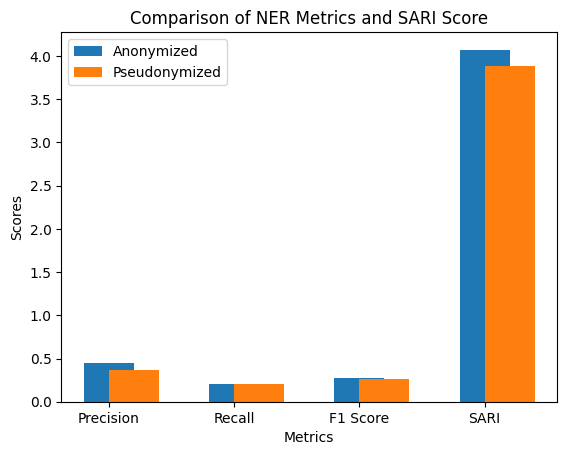

In [26]:


sari = load("sari")

def calculate_sari_avg(source_sentences, simplified_sentences):
    scores = [
        sari.compute(sources=[src], predictions=[pred], references=[[src]])['sari']
        for src, pred in zip(source_sentences, simplified_sentences)
        if pred.strip() 
    ]
    return sum(scores) / len(scores) if scores else 0


source_sentences = sent_tokenize(text)

simplified_sentences1 = sent_tokenize(simplified_anonymized_result)
simplified_sentences2 = sent_tokenize(simplified_pseudonymized_result)

sari_score_anonymized = calculate_sari_avg(source_sentences, simplified_sentences1)
sari_score_pseudonymized = calculate_sari_avg(source_sentences, simplified_sentences2)

print(f"SARI Score for Simplified Anonymized Result: {sari_score_anonymized}")
print(f"SARI Score for Simplified Pseudonymized Result: {sari_score_pseudonymized}")

nlp = spacy.load("nl_core_news_lg")

def extract_entities(text):
    doc = nlp(text)
    return [(ent.text, ent.label_) for ent in doc.ents]

original_entities = extract_entities(text)

def compare_entities(original_entities, simplified_entities):
    original_set = set(original_entities)
    simplified_set = set(simplified_entities)
    
    true_positives = original_set & simplified_set
    false_positives = simplified_set - original_set
    false_negatives = original_set - simplified_set
    
    y_true = [1 if ent in original_set else 0 for ent in original_set | simplified_set]
    y_pred = [1 if ent in simplified_set else 0 for ent in original_set | simplified_set]
    
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary')
    
    return precision, recall, f1, true_positives, false_positives, false_negatives

simplified_anonymized_entities = extract_entities(simplified_anonymized_result)
simplified_pseudonymized_entities = extract_entities(simplified_pseudonymized_result)

precision_anonymized, recall_anonymized, f1_anonymized, true_positives_anonymized, false_positives_anonymized, false_negatives_anonymized = compare_entities(original_entities, simplified_anonymized_entities)

print("Simplified Anonymized Result:")
print(f"Precision: {precision_anonymized}")
print(f"Recall: {recall_anonymized}")
print(f"F1 Score: {f1_anonymized}")
print(f"True Positives: {true_positives_anonymized}")
print(f"False Positives: {false_positives_anonymized}")
print(f"False Negatives: {false_negatives_anonymized}")

precision_pseudonymized, recall_pseudonymized, f1_pseudonymized, true_positives_pseudonymized, false_positives_pseudonymized, false_negatives_pseudonymized = compare_entities(original_entities, simplified_pseudonymized_entities)

print("\nSimplified Pseudonymized Result:")
print(f"Precision: {precision_pseudonymized}")
print(f"Recall: {recall_pseudonymized}")
print(f"F1 Score: {f1_pseudonymized}")
print(f"True Positives: {true_positives_pseudonymized}")
print(f"False Positives: {false_positives_pseudonymized}")
print(f"False Negatives: {false_negatives_pseudonymized}")

labels = ['Precision', 'Recall', 'F1 Score', 'SARI']
anonymized_scores = [precision_anonymized, recall_anonymized, f1_anonymized, sari_score_anonymized]
pseudonymized_scores = [precision_pseudonymized, recall_pseudonymized, f1_pseudonymized, sari_score_pseudonymized]

x = range(len(labels))

fig, ax = plt.subplots()
ax.bar(x, anonymized_scores, width=0.4, label='Anonymized', align='center')
ax.bar(x, pseudonymized_scores, width=0.4, label='Pseudonymized', align='edge')

ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('Comparison of NER Metrics and SARI Score')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

plt.show()
